## Reddit data-set for sarcasm detection (pt 1)

The Sarcasm on Reddit dataset provides comments posted on Reddit labeled as sarcastic (1) or not sarcastic (0).
The task of the project is, given only the parent comment and the Reddit category (subreddit), to predict the probability of a parent comment to receive a sarcastic comment.

Download the dataset and unzip it.

In [1]:
#import kaggle
#kaggle.api.authenticate()
#kaggle.api.dataset_download_files('danofer/sarcasm', unzip=True)

In [2]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib
from matplotlib import pyplot as plt
from scipy.sparse import hstack
import nltk
nltk.download('vader_lexicon') # VADER (Valence Aware Dictionary and sEntiment Reasoner) is a sentiment intensity tool added to NLTK in 2014
nltk.download('punkt')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
# Importing the Keras libraries and packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as lg
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\liry9\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\liry9\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import tensorflow as tf
import os
from tensorflow import keras

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.3.0


In [4]:
# Importing the Keras libraries and packages
from keras import backend as K
from keras.utils import to_categorical
from keras.layers import Dense, ZeroPadding2D, AveragePooling2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import InceptionResNetV2
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical

In [5]:
import spacy
spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser = English()
from textblob import TextBlob

## Data-set analysis

We import the data and analyze it.

As the creator of the dataset states the Reddit dataset contains 1.3 million Sarcastic comments from the Internet commentary website Reddit and it was generated by scraping comments from Reddit containing the \s (sarcasm) tag. This tag is often used by Redditors to indicate that their comment is in jest and not meant to be taken seriously, and is generally a reliable indicator of sarcastic comment content.

In [6]:
red = pd.read_csv('C:/Users/liry9/Desktop/Text Mining and Sentiment Analysis/Project/Dataset/train-balanced-sarcasm.csv')
red.head(10)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
5,0,"I don't pay attention to her, but as long as s...",only7inches,AskReddit,0,0,0,2016-09,2016-09-02 10:35:08,do you find ariana grande sexy ?
6,0,Trick or treating in general is just weird...,only7inches,AskReddit,1,-1,-1,2016-10,2016-10-23 21:43:03,What's your weird or unsettling Trick or Treat...
7,0,Blade Mastery+Masamune or GTFO!,P0k3rm4s7,FFBraveExvius,2,-1,-1,2016-10,2016-10-13 21:13:55,Probably Sephiroth. I refuse to taint his grea...
8,0,"You don't have to, you have a good build, buy ...",SoupToPots,pcmasterrace,1,-1,-1,2016-10,2016-10-27 19:11:06,What to upgrade? I have $500 to spend (mainly ...
9,0,I would love to see him at lolla.,chihawks,Lollapalooza,2,-1,-1,2016-11,2016-11-21 23:39:12,Probably count Kanye out Since the rest of his...


In [7]:
print(red.shape[0])  # gives number of row count
print(red.shape[1])  # gives number of col count

1010826
10


In [8]:
print(red['parent_comment'][5])
print(red['comment'][5])
print(red['label'][5])

do you find ariana grande sexy ?
I don't pay attention to her, but as long as she's legal I wouldn't kick her out of bed (before she took a load)
0


The analysis will begin by focusing on a small sample of the dataset since as it is possible to observe from the previous command the dataset (not yet pre-processed) contains 1010826 rows, 962295 unique values (as for what concerns the comments' column) and 984286 unique values (for the parent comment section). The difference between the total number of rows of the data frame, that of the comments and the ones of the parent comments implies that there are some nan values. As a matter of fact:

In [9]:
red.isnull().sum() # There are 53 nan values for the comments' column

label              0
comment           53
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

In [10]:
red = red[red['comment'].notna()]
red.isnull().sum()

label             0
comment           0
author            0
subreddit         0
score             0
ups               0
downs             0
date              0
created_utc       0
parent_comment    0
dtype: int64

In [11]:
red_sample = red.sample(frac = 0.1) ## Since the original dataset is huge, we will work with a small sample of it
print(red_sample.shape[0])  # gives number of row count
print(red_sample.shape[1])  # gives number of col count

101077
10


In [12]:
## Let's check the number of unique values in the label columns: this operation should confirm that we only have two labels:
# 0 = non sarcastic comment
# 1 = sarcastic comment
red_sample['label'].nunique()

2

Based on the information given by its owner the dataset should be balanced, this however an analysis of the distribution of the labels will follow, in order to check whether we need to adjust the class distribution of our dataset using adapting techniques such as oversampling or undersampling.

C:\Users\liry9\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

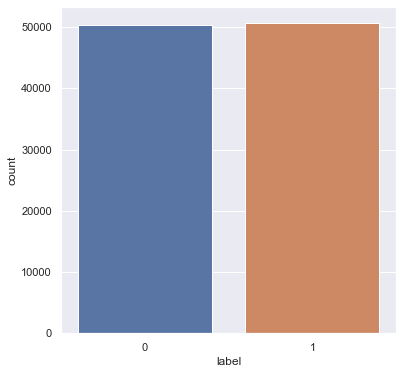

In [13]:
sns.set(rc={'figure.figsize':(6,6)})
sns.countplot(red_sample['label']) # The dataset, or in this case the sample, is confirmed to be balanced

Let's consider one comment to undrstand tokenization, lemmatization, stopwords removal and POS tagging.

In [14]:
example = red['parent_comment'][0]

In [15]:
example

"Yeah, I get that argument. At this point, I'd prefer is she lived in NC as well."

In [16]:
example_comment = red['comment'][0]

In [17]:
example_comment

'NC and NH.'

In [18]:
example_label = red['label'][0]
example_label

0

In [19]:
## Example of SENTENCE tokenization
from nltk.tokenize import sent_tokenize
tokenized_sentence_example = sent_tokenize(example)
print(tokenized_sentence_example)

['Yeah, I get that argument.', "At this point, I'd prefer is she lived in NC as well."]


In [20]:
## Example of WORD tokenization
from nltk.tokenize import word_tokenize
tokenized_word_example = word_tokenize(example)
print(tokenized_word_example)

['Yeah', ',', 'I', 'get', 'that', 'argument', '.', 'At', 'this', 'point', ',', 'I', "'d", 'prefer', 'is', 'she', 'lived', 'in', 'NC', 'as', 'well', '.']


In [21]:
## Word frequency distribution
from nltk.probability import FreqDist
freqDistrib = FreqDist(tokenized_word_example)
print(freqDistrib)

<FreqDist with 19 samples and 22 outcomes>


In [22]:
freqDistrib.most_common(3)

[(',', 2), ('I', 2), ('.', 2)]

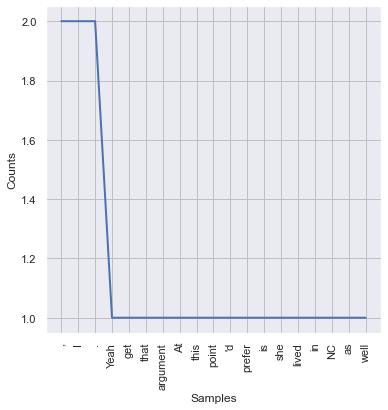

In [23]:
freqDistrib.plot(30,cumulative=False)
plt.show()

In [24]:
stop_words=set(stopwords.words("english"))
print(stop_words)

{"she's", 'her', 'haven', 'our', "you've", 'will', 'how', 'y', 'again', 'hers', 'shouldn', 'themselves', 'it', 'does', 'having', 'out', "mightn't", 'aren', 'by', "hasn't", 'the', 'd', 'off', 'wouldn', 'same', "it's", 'who', 'once', 'that', "mustn't", 'was', 'isn', 'me', 'you', 'during', 'only', "you'll", 'be', 'yours', 'had', 'nor', 'before', 'own', 'can', 'are', 'being', 'is', 'some', 'ourselves', 'been', 'not', 'm', 'under', "isn't", "should've", 'she', 'my', 'what', 'himself', 'with', 'below', 'about', "aren't", 'ain', 'hadn', 'too', "couldn't", 'i', 'its', 'if', 'each', 'because', 'doesn', 'here', 'do', 'wasn', 'through', 'further', "weren't", 'were', 'into', 'there', 'for', 'of', 'shan', 'all', "you're", 'more', 'where', 'those', 'mustn', 'needn', 'a', 'ma', "wasn't", "that'll", 'from', 'why', 'doing', 'couldn', 'weren', 'when', 'any', 'few', 'mightn', 'theirs', 'am', "hadn't", 'o', 'he', 'yourselves', 'won', 'they', 'than', 'in', 'this', 'these', 'while', "haven't", 'at', "wouldn

In [25]:
filteredSentence = []
for w in tokenized_sentence_example:
    if w not in stop_words:
        filteredSentence.append(w)
print("Tokenized Sentence:",tokenized_sentence_example)
print("Filterd Sentence:",filteredSentence)

Tokenized Sentence: ['Yeah, I get that argument.', "At this point, I'd prefer is she lived in NC as well."]
Filterd Sentence: ['Yeah, I get that argument.', "At this point, I'd prefer is she lived in NC as well."]


In [26]:
## Stemming
from nltk.stem import PorterStemmer

stemmedWords=[]
for w in filteredSentence:
    stemmedWords.append(PorterStemmer().stem(w))

print("Filtered Sentence:",filteredSentence)
print("Stemmed Sentence:",stemmedWords)

Filtered Sentence: ['Yeah, I get that argument.', "At this point, I'd prefer is she lived in NC as well."]
Stemmed Sentence: ['yeah, i get that argument.', "at this point, i'd prefer is she lived in nc as well."]


In [27]:
## Lemmatization
from nltk.stem.wordnet import WordNetLemmatizer

word = "pretty"
print("Lemmatized Word:",WordNetLemmatizer().lemmatize(word))
print("Stemmed Word:",PorterStemmer().stem(word))

Lemmatized Word: pretty
Stemmed Word: pretti


In [28]:
## POS tagging
nltk.download('averaged_perceptron_tagger')
nltk.pos_tag(tokenized_word_example)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\liry9\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('Yeah', 'UH'),
 (',', ','),
 ('I', 'PRP'),
 ('get', 'VBP'),
 ('that', 'DT'),
 ('argument', 'NN'),
 ('.', '.'),
 ('At', 'IN'),
 ('this', 'DT'),
 ('point', 'NN'),
 (',', ','),
 ('I', 'PRP'),
 ("'d", 'MD'),
 ('prefer', 'VB'),
 ('is', 'VBZ'),
 ('she', 'PRP'),
 ('lived', 'VBD'),
 ('in', 'IN'),
 ('NC', 'NNP'),
 ('as', 'RB'),
 ('well', 'RB'),
 ('.', '.')]

### Dependency parser

In [29]:
nlp = spacy.load("en_core_web_sm")

In [30]:
from spacy import displacy

In [31]:
s_example = nlp(example)

In [32]:
displacy.render(s_example, style='dep')

## Distribution of sarcastic and non sarcastic comments

In order to compute what is the probability that given only the subreddit and the parent comment, the parent comment is associated with a sarcastic comment it is necessary to drop all the other columns.

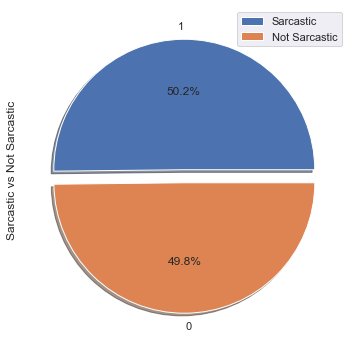

In [33]:
# Pie chart
red_sample["label"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Sarcastic vs Not Sarcastic")
plt.legend(["Sarcastic", "Not Sarcastic"])
plt.show()

### Exploratory Analysis

It might be interesting to perform some exploratory analysis on the dataset.

In [34]:
## Number of unique comment author
red_sample['author'].nunique()

74288

In [35]:
## Number of unique subreddit
red_sample['subreddit'].nunique()

5606

In [36]:
# Create a copy of the original dataset
red_copy = red_sample.copy()

Focusing on the column of the comments.

In [37]:
## Group and count the comments by author and label
red_sample.groupby(['author', 'label'],as_index=False).agg({'comment':'count'})

,author,label,comment
0,---,1,1
1,--------__--------,1,1
2,-----BroAway-----,0,1
3,----branflakes----,0,1
4,---Earth---,0,3
...,...,...,...
85806,zzyxxy,1,1
85807,zzzzz94,0,1
85808,zzzzz94,1,1
85809,zzzzzzzzzzzzzzzzspaf,0,1


In [38]:
## Return the number of sarcastic comment per each author
sarcasm_count_by_author = red_sample.groupby('author')['label'].agg([np.sum])
sarcasm_count_by_author

,sum
author,
---,1
--------__--------,1
-----BroAway-----,0
----branflakes----,0
---Earth---,2
...,...
zzxyyzx,1
zzyul,0
zzyxxy,1


In [39]:
## Group and count the comments by author
comment_count_by_author = red_sample.groupby(['author'],as_index=False).agg({'comment':'count'})
comment_count_by_author

,author,comment
0,---,1
1,--------__--------,1
2,-----BroAway-----,1
3,----branflakes----,1
4,---Earth---,5
...,...,...
74283,zzxyyzx,1
74284,zzyul,1
74285,zzyxxy,1
74286,zzzzz94,2


In [40]:
comment_sum_up = pd.merge(sarcasm_count_by_author, comment_count_by_author, on='author')
comment_sum_up

,author,sum,comment
0,---,1,1
1,--------__--------,1,1
2,-----BroAway-----,0,1
3,----branflakes----,0,1
4,---Earth---,2,5
...,...,...,...
74283,zzxyyzx,1,1
74284,zzyul,0,1
74285,zzyxxy,1,1
74286,zzzzz94,1,2


In [41]:
comment_sum_up['percentage of sarcastic comments'] = comment_sum_up['sum']/comment_sum_up['comment']
comment_sum_up

,author,sum,comment,percentage of sarcastic comments
0,---,1,1,1.000000
1,--------__--------,1,1,1.000000
2,-----BroAway-----,0,1,0.000000
3,----branflakes----,0,1,0.000000
4,---Earth---,2,5,0.400000
...,...,...,...,...
74283,zzxyyzx,1,1,1.000000
74284,zzyul,0,1,0.000000
74285,zzyxxy,1,1,1.000000
74286,zzzzz94,1,2,0.500000


In [42]:
## Most sarcastic author:
print("The most sarastic author is: %15s" % (comment_count_by_author['author'].loc[comment_count_by_author['comment'].idxmax()]))

The most sarastic author is:     Biffingston


Some further analysis

In [43]:
## Group and count the comments by author and label
red_sample.groupby(['subreddit', 'label'],as_index=False).agg({'comment':'count'})

,subreddit,label,comment
0,112263Hulu,0,1
1,1200isplenty,0,1
2,195,0,1
3,195,1,1
4,19KidsandCounting,1,1
...,...,...,...
8017,zoloft,0,1
8018,zombies,1,2
8019,zootopia,0,3
8020,zootopia,1,1


In [44]:
## Return the number of sarcastic comment per each subreddit
sarcasm_count_by_subreddit = red_sample.groupby('subreddit')['label'].agg([np.sum])
sarcasm_count_by_subreddit

,sum
subreddit,
112263Hulu,0
1200isplenty,0
195,1
19KidsandCounting,1
2007oneclan,0
...,...
zoidberg,0
zoloft,0
zombies,2


In [45]:
## Group and count the comments by author
comment_count_by_subreddit = red_sample.groupby(['subreddit'],as_index=False).agg({'comment':'count'})
comment_count_by_subreddit

,subreddit,comment
0,112263Hulu,1
1,1200isplenty,1
2,195,2
3,19KidsandCounting,1
4,2007oneclan,1
...,...,...
5601,zoidberg,1
5602,zoloft,1
5603,zombies,2
5604,zootopia,4


In [46]:
subreddit_comment_sum_up = pd.merge(sarcasm_count_by_subreddit, comment_count_by_subreddit, on='subreddit')
subreddit_comment_sum_up

,subreddit,sum,comment
0,112263Hulu,0,1
1,1200isplenty,0,1
2,195,1,2
3,19KidsandCounting,1,1
4,2007oneclan,0,1
...,...,...,...
5601,zoidberg,0,1
5602,zoloft,0,1
5603,zombies,2,2
5604,zootopia,1,4


In [47]:
subreddit_comment_sum_up['percentage of sarcastic comments'] = subreddit_comment_sum_up['sum']/subreddit_comment_sum_up['comment']
subreddit_comment_sum_up

,subreddit,sum,comment,percentage of sarcastic comments
0,112263Hulu,0,1,0.00
1,1200isplenty,0,1,0.00
2,195,1,2,0.50
3,19KidsandCounting,1,1,1.00
4,2007oneclan,0,1,0.00
...,...,...,...,...
5601,zoidberg,0,1,0.00
5602,zoloft,0,1,0.00
5603,zombies,2,2,1.00
5604,zootopia,1,4,0.25


In [48]:
## Most sarcastic subreddit
print("The most sarastic subreddit is: %15s" % (comment_count_by_subreddit['subreddit'].loc[comment_count_by_subreddit['comment'].idxmax()]))

The most sarastic subreddit is:       AskReddit


In [49]:
subreddits = red_sample['subreddit'].value_counts()

In [50]:
pd.DataFrame(subreddits)

,subreddit
AskReddit,6539
politics,3888
worldnews,2645
leagueoflegends,2074
pcmasterrace,1871
...,...
indiegameswap,1
Darkroom,1
pcgamingtechsupport,1
PokemonGoSanJose,1


In [51]:
top_ten = subreddits.head(10)
top_ten = pd.DataFrame(top_ten)

In [52]:
top_ten['sub'] = top_ten.index

In [53]:
top_ten

,subreddit,sub
AskReddit,6539,AskReddit
politics,3888,politics
worldnews,2645,worldnews
leagueoflegends,2074,leagueoflegends
pcmasterrace,1871,pcmasterrace
funny,1789,funny
news,1665,news
pics,1587,pics
todayilearned,1463,todayilearned
GlobalOffensive,1445,GlobalOffensive


In [54]:
top_ten = top_ten.reset_index(drop=True)
top_ten

,subreddit,sub
0,6539,AskReddit
1,3888,politics
2,2645,worldnews
3,2074,leagueoflegends
4,1871,pcmasterrace
5,1789,funny
6,1665,news
7,1587,pics
8,1463,todayilearned
9,1445,GlobalOffensive


In [55]:
df = red_sample[red_sample.set_index(['subreddit']).index.isin(top_ten.set_index(['sub']).index)]
df = pd.DataFrame(df)

In [56]:
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
850040,1,Albanian infidels everywhere tremble before yo...,screw_this_i_quit,worldnews,1,1,0,2014-10,2014-10-15 22:21:26,Serbia accuses Albania of provocation after brawl
209638,1,i'm sure these terrorists would have handed th...,xnodesirex,news,18,18,0,2016-07,2016-07-08 06:27:20,"Hand over your guns guys, christ, get a grip."
425825,1,wow must be great for the NBA to have the righ...,wolfsfang,politics,-6,-6,0,2016-04,2016-04-21 23:13:27,Finally something they'll pay attention to
453158,1,"What's the point of owning a gun, if not to sh...",apsodijfpaoisjdpfoij,todayilearned,1,1,0,2016-04,2016-04-03 06:45:13,"That's why if you concealed carry, you keep it..."
531555,1,I never knew reddit had so many boxing experts.,Palchez,funny,2,2,0,2015-07,2015-07-16 15:31:45,I give him 30 seconds.


In [57]:
#df.loc[df.label == '1', df.subreddit == 'AskReddit'].count()
print(df[(df['label']==1) & (df['subreddit']=='AskReddit')].count())
print(df[(df['label']==0) & (df['subreddit']=='AskReddit')].count())

label             2670
comment           2670
author            2670
subreddit         2670
score             2670
ups               2670
downs             2670
date              2670
created_utc       2670
parent_comment    2670
dtype: int64
label             3869
comment           3869
author            3869
subreddit         3869
score             3869
ups               3869
downs             3869
date              3869
created_utc       3869
parent_comment    3869
dtype: int64


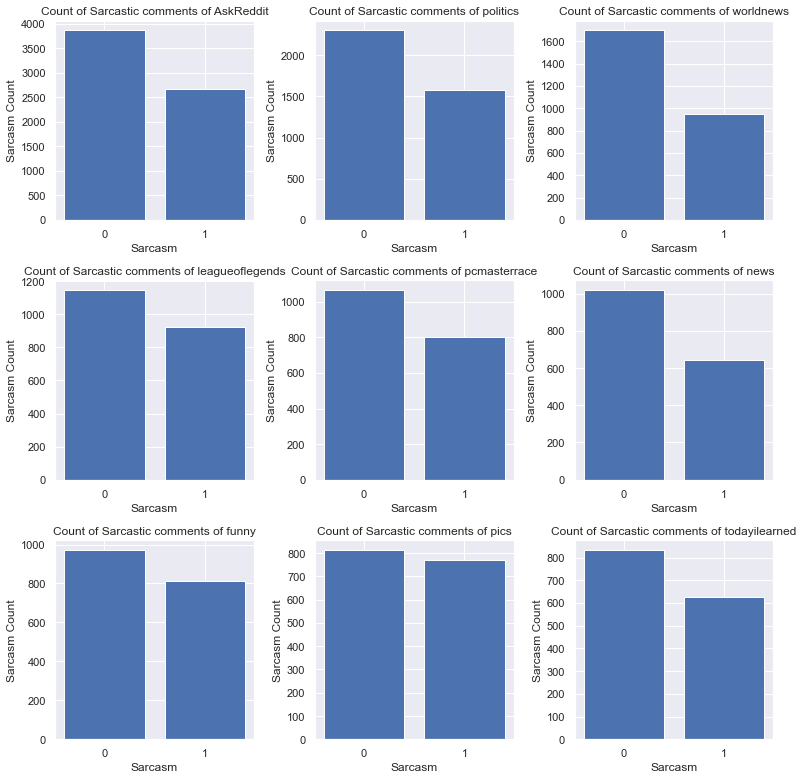

In [58]:
def plot_sub_sentiment(sub):
    dataFrame=df[df['subreddit']==sub]
    count=dataFrame['label'].value_counts()
    Index = [1,2]
    plt.bar(Index,count)
    plt.xticks(Index,['0','1'])
    plt.ylabel('Sarcasm Count')
    plt.xlabel('Sarcasm')
    plt.title('Count of Sarcastic comments of '+sub)
    plt.tight_layout()

plt.figure(1,figsize=(11, 11))
plt.subplot(331)
plot_sub_sentiment('AskReddit')
plt.subplot(332)
plot_sub_sentiment('politics')
plt.subplot(333)
plot_sub_sentiment('worldnews')
plt.subplot(334)
plot_sub_sentiment('leagueoflegends')
plt.subplot(335)
plot_sub_sentiment('pcmasterrace')
plt.subplot(337)
plot_sub_sentiment('funny')
plt.subplot(336)
plot_sub_sentiment('news')
plt.subplot(338)
plot_sub_sentiment('pics')
plt.subplot(339)
plot_sub_sentiment('todayilearned')

#plt.savefig('C:/Users/liry9/Desktop/Text Mining and Sentiment Analysis/Project/images/sarcasm_count_per_subreddit.pdf')

C:\Users\liry9\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 1.0, 'Sarcastic comments for "GlobalOffensive"')]

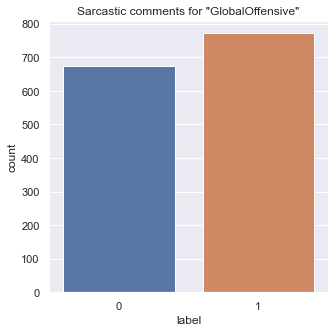

In [59]:
df_leagueoflegends = red_sample[red_sample['subreddit']==top_ten['sub'][9]]
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(df_leagueoflegends['label']).set(title = 'Sarcastic comments for "GlobalOffensive"')

Let's print out the highest and the lowest scores first and then the corresponding comment and parent comment.

In [60]:
print("The minimum score assigned to a comment is %d, while the highest one is %d" % (red_sample['score'].min(), red_sample['score'].max()))

The minimum score assigned to a comment is -129, while the highest one is 7563


In [61]:
print('The Parent Comment of the comment with the highest score is:\n',red_sample['parent_comment'].loc[red_sample['score'].idxmax()])
print('\n The Comment with the highest score is:\n',red_sample['comment'].loc[red_sample['score'].idxmax()])
if red_sample['label'].loc[red_sample['score'].idxmax()]==1:
    print('\n sarcastic')
else:
    print('\n not sarcastic')

The Parent Comment of the comment with the highest score is:
 Facts for those who dispute man-made climate chage: co2 is a greenhouse gas Historically, when co2 went up, the planet warmed. We are producing a lot of co2. We are eliminating much of the plants' and oceans' ability to remove co2 The earth is getting warmer. Now, taking all of those into consideration, there's only one logical conclusion.

 The Comment with the highest score is:
 but it still snows

 sarcastic


In [62]:
red_sample.loc[red_sample['score'].idxmax()]

label                                                             1
comment                                          but it still snows
author                                                       Zoso03
subreddit                                                 worldnews
score                                                          7563
ups                                                              -1
downs                                                            -1
date                                                        2016-12
created_utc                                     2016-12-08 14:53:25
parent_comment    Facts for those who dispute man-made climate c...
Name: 157472, dtype: object

In [63]:
## Lowest score comment and its parent comment
print('The Parent Comment of the comment with the lowest score is:\n',red_sample['parent_comment'].loc[red_sample['score'].idxmin()])
print('\n The Comment with the lowest score is:\n',red_sample['comment'].loc[red_sample['score'].idxmin()])
if red_sample['label'].loc[red_sample['score'].idxmin()]==1:
    print('\n sarcastic')
else:
    print('\n non sarcastic')

The Parent Comment of the comment with the lowest score is:
 This is exactly why abortion shouldn't even be a debate, IMO.

 The Comment with the lowest score is:
 Let's also legalize all drugs, guns and sex acts because it will put them under control.

 sarcastic


In [64]:
red_sample.loc[red_sample['score'].idxmin()]

label                                                             1
comment           Let's also legalize all drugs, guns and sex ac...
author                                                      lamponi
subreddit                                             MorbidReality
score                                                          -129
ups                                                            -129
downs                                                             0
date                                                        2013-06
created_utc                                     2013-06-27 05:27:05
parent_comment    This is exactly why abortion shouldn't even be...
Name: 919343, dtype: object

Analysis on the scores

In [65]:
# Mean and STD of Score Rating
mean = red_sample['score'].mean()
std = red_sample['score'].std()
print(mean, std)

7.028176538678434 55.71279428744863


## Text analysis

In [66]:
list(red_sample.columns)

['label',
 'comment',
 'author',
 'subreddit',
 'score',
 'ups',
 'downs',
 'date',
 'created_utc',
 'parent_comment']

In [67]:
red_copy.drop(['comment', 'author', 'score', 'date', 'created_utc'], axis=1, inplace=True) # rimangono ups and downs
red_copy.head(10)

,label,subreddit,ups,downs,parent_comment
65121,0,ApplyingToCollege,-1,-1,"Oh shit, I wrote about reddit as one of my ess..."
279501,1,atheism,4,0,Sacramento Baptist Preacher Praises Orlando Ga...
208156,1,videos,4,0,Why isnt this criminal assualt? Are the police...
850040,1,worldnews,1,0,Serbia accuses Albania of provocation after brawl
209638,1,news,18,0,"Hand over your guns guys, christ, get a grip."
425825,1,politics,-6,0,Finally something they'll pay attention to
453158,1,todayilearned,1,0,"That's why if you concealed carry, you keep it..."
360963,0,dayz,1,0,"I have 500 hrs in DayZ, and it's my favourite ..."
531555,1,funny,2,0,I give him 30 seconds.
55635,1,WorldofTanksConsole,5,0,"Wtf, platoons allowed in the Mark I? 5 man out..."


In [68]:
# Find the number of characters for each string in the red_sample dataset
red_copy['char'] = red_copy['parent_comment'].str.len()
red_copy.head()

,label,subreddit,ups,downs,parent_comment,char
65121,0,ApplyingToCollege,-1,-1,"Oh shit, I wrote about reddit as one of my ess...",50
279501,1,atheism,4,0,Sacramento Baptist Preacher Praises Orlando Ga...,64
208156,1,videos,4,0,Why isnt this criminal assualt? Are the police...,68
850040,1,worldnews,1,0,Serbia accuses Albania of provocation after brawl,49
209638,1,news,18,0,"Hand over your guns guys, christ, get a grip.",45


In [69]:
def plotDistr(var):
    plt.hist(red_copy[var][red_copy['label']==0], density=True, label='Not Sarcastic')
    plt.hist(red_copy[var][red_copy['label']==1], density=True, label='Sarcastic')
    plt.legend()
    plt.show()

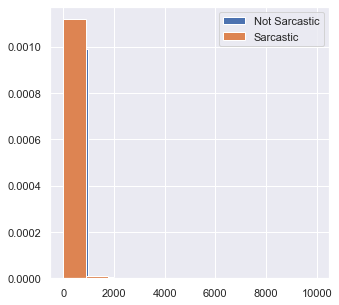

In [70]:
plotDistr('char')

In [71]:
# Number of punctuation symbols
red_copy['punct'] = red_copy['parent_comment'].str.findall(r'[^a-zA-Z\d\s:]').str.len()
red_copy.head()

,label,subreddit,ups,downs,parent_comment,char,punct
65121,0,ApplyingToCollege,-1,-1,"Oh shit, I wrote about reddit as one of my ess...",50,2
279501,1,atheism,4,0,Sacramento Baptist Preacher Praises Orlando Ga...,64,0
208156,1,videos,4,0,Why isnt this criminal assualt? Are the police...,68,2
850040,1,worldnews,1,0,Serbia accuses Albania of provocation after brawl,49,0
209638,1,news,18,0,"Hand over your guns guys, christ, get a grip.",45,3


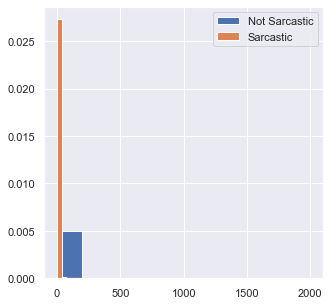

In [72]:
plotDistr('punct')

In [73]:
# Find the number of tokens for each string in the red_sample dataset
red_copy['tokens'] = red_copy['parent_comment'].str.split().str.len()
red_copy.head()

,label,subreddit,ups,downs,parent_comment,char,punct,tokens
65121,0,ApplyingToCollege,-1,-1,"Oh shit, I wrote about reddit as one of my ess...",50,2,11
279501,1,atheism,4,0,Sacramento Baptist Preacher Praises Orlando Ga...,64,0,8
208156,1,videos,4,0,Why isnt this criminal assualt? Are the police...,68,2,13
850040,1,worldnews,1,0,Serbia accuses Albania of provocation after brawl,49,0,7
209638,1,news,18,0,"Hand over your guns guys, christ, get a grip.",45,3,9


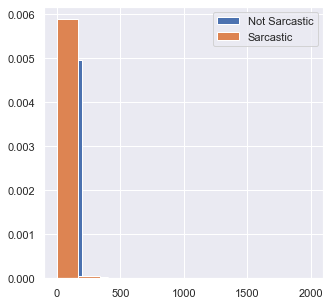

In [74]:
plotDistr('tokens')

In [75]:
# Cleaning the text of the parents' comments
stemmer = SnowballStemmer("english")

def cleanText(x):
    words = [stemmer.stem(word) for word in nltk.word_tokenize(x.lower()) if word.isalpha() and word not in stopwords.words("english")]
    return " ".join(words)

In [76]:
from timeit import default_timer as timer

# get the starting time
startTime = timer()

red_copy["clean"] = red_copy["parent_comment"].apply(cleanText)
red_copy.head()
endTime = timer()

In [77]:
# Get the time needed for stemming all the parent comments and return the cleared texts
print("Time needed to clear the comments is: {} minutes and {:.1f} seconds".format((endTime - startTime)//60, (endTime - startTime)%60))

Time needed to clear the comments is: 16.0 minutes and 52.2 seconds


### Sentiment analysis

In [78]:
red_copy.reset_index(inplace=True)
red_copy.drop(['index'], axis=1, inplace=True)
red_copy.head()

,label,subreddit,ups,downs,parent_comment,char,punct,tokens,clean
0,0,ApplyingToCollege,-1,-1,"Oh shit, I wrote about reddit as one of my ess...",50,2,11,oh shit wrote reddit one essay
1,1,atheism,4,0,Sacramento Baptist Preacher Praises Orlando Ga...,64,0,8,sacramento baptist preacher prais orlando gay ...
2,1,videos,4,0,Why isnt this criminal assualt? Are the police...,68,2,13,isnt crimin assualt polic fuck tsa
3,1,worldnews,1,0,Serbia accuses Albania of provocation after brawl,49,0,7,serbia accus albania provoc brawl
4,1,news,18,0,"Hand over your guns guys, christ, get a grip.",45,3,9,hand gun guy christ get grip


In [79]:
all_parent_comments = red_copy['parent_comment']
all_sent_values = []
all_sentiments = []

In [80]:
def sentiment_value(paragraph):
    analyser = SentimentIntensityAnalyzer()
    result = analyser.polarity_scores(paragraph)
    score = result['compound']
    return round(score,1)

In [81]:
sample = red_copy['parent_comment'][1231]
print(sample)
print('Sentiment: ')
print(sentiment_value(sample))

It takes me two hours to get home every day from school. Here's a video I made of my trip.
Sentiment: 
0.0


In [82]:
for i in range(0, red_copy.shape[0]):
    all_sent_values.append(sentiment_value(red_copy['parent_comment'][i]))

In [83]:
len(all_sent_values)

101077

In [84]:
all_parent_comments = pd.DataFrame(all_parent_comments)
all_parent_comments

,parent_comment
0,"Oh shit, I wrote about reddit as one of my ess..."
1,Sacramento Baptist Preacher Praises Orlando Ga...
2,Why isnt this criminal assualt? Are the police...
3,Serbia accuses Albania of provocation after brawl
4,"Hand over your guns guys, christ, get a grip."
...,...
101072,*It seems as if pure mathematics reveals the t...
101073,I used a bugged killstreak kit to make my Saxx...
101074,Love how he looks around as if someone else is...
101075,Negative. I am a meat popsicle.


In [85]:
#Sentiment Analysis on the dataset
SENTIMENT_VALUE = []
SENTIMENT = []
for i in range(0, red_copy.shape[0]):
    sent = all_sent_values[i]
    if (sent<=1 and sent>=0.5):
        SENTIMENT.append('Highly Positive')
        SENTIMENT_VALUE.append(5)
    elif (sent<0.5 and sent>0):
        SENTIMENT.append('Positive')
        SENTIMENT_VALUE.append(4)
    elif (sent==0):
        SENTIMENT.append('Neutral')
        SENTIMENT_VALUE.append(3)
    elif (sent<0 and sent>=-0.5):
        SENTIMENT.append('Negative')
        SENTIMENT_VALUE.append(2)
    else:
        SENTIMENT.append('Highly Negative')
        SENTIMENT_VALUE.append(1)

In [86]:
all_parent_comments['sentiment_value'] = SENTIMENT_VALUE
all_parent_comments['sentiment'] = SENTIMENT

In [87]:
all_parent_comments

,parent_comment,sentiment_value,sentiment
0,"Oh shit, I wrote about reddit as one of my ess...",1,Highly Negative
1,Sacramento Baptist Preacher Praises Orlando Ga...,4,Positive
2,Why isnt this criminal assualt? Are the police...,2,Negative
3,Serbia accuses Albania of provocation after brawl,2,Negative
4,"Hand over your guns guys, christ, get a grip.",5,Highly Positive
...,...,...,...
101072,*It seems as if pure mathematics reveals the t...,4,Positive
101073,I used a bugged killstreak kit to make my Saxx...,3,Neutral
101074,Love how he looks around as if someone else is...,4,Positive
101075,Negative. I am a meat popsicle.,1,Highly Negative


In [88]:
red_final = pd.merge(red_copy, all_parent_comments, left_index=True, right_index=True)

In [89]:
del red_final['parent_comment_y']
red_final

,label,subreddit,ups,downs,parent_comment_x,char,punct,tokens,clean,sentiment_value,sentiment
0,0,ApplyingToCollege,-1,-1,"Oh shit, I wrote about reddit as one of my ess...",50,2,11,oh shit wrote reddit one essay,1,Highly Negative
1,1,atheism,4,0,Sacramento Baptist Preacher Praises Orlando Ga...,64,0,8,sacramento baptist preacher prais orlando gay ...,4,Positive
2,1,videos,4,0,Why isnt this criminal assualt? Are the police...,68,2,13,isnt crimin assualt polic fuck tsa,2,Negative
3,1,worldnews,1,0,Serbia accuses Albania of provocation after brawl,49,0,7,serbia accus albania provoc brawl,2,Negative
4,1,news,18,0,"Hand over your guns guys, christ, get a grip.",45,3,9,hand gun guy christ get grip,5,Highly Positive
...,...,...,...,...,...,...,...,...,...,...,...
101072,0,philosophy,-1,-1,*It seems as if pure mathematics reveals the t...,123,5,18,seem pure mathemat reveal topographi region wh...,4,Positive
101073,1,tf2,32,0,I used a bugged killstreak kit to make my Saxx...,91,2,16,use bug killstreak kit make saxxi profession k...,3,Neutral
101074,0,soccer,-1,-1,Love how he looks around as if someone else is...,56,1,12,love look around someon els blame,4,Positive
101075,0,AdviceAnimals,2,0,Negative. I am a meat popsicle.,31,2,6,negat meat popsicl,1,Highly Negative


In [90]:
red_final.rename(columns={'parent_comment_x':'parent_comment'}, inplace=True)
red_final

,label,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,sentiment_value,sentiment
0,0,ApplyingToCollege,-1,-1,"Oh shit, I wrote about reddit as one of my ess...",50,2,11,oh shit wrote reddit one essay,1,Highly Negative
1,1,atheism,4,0,Sacramento Baptist Preacher Praises Orlando Ga...,64,0,8,sacramento baptist preacher prais orlando gay ...,4,Positive
2,1,videos,4,0,Why isnt this criminal assualt? Are the police...,68,2,13,isnt crimin assualt polic fuck tsa,2,Negative
3,1,worldnews,1,0,Serbia accuses Albania of provocation after brawl,49,0,7,serbia accus albania provoc brawl,2,Negative
4,1,news,18,0,"Hand over your guns guys, christ, get a grip.",45,3,9,hand gun guy christ get grip,5,Highly Positive
...,...,...,...,...,...,...,...,...,...,...,...
101072,0,philosophy,-1,-1,*It seems as if pure mathematics reveals the t...,123,5,18,seem pure mathemat reveal topographi region wh...,4,Positive
101073,1,tf2,32,0,I used a bugged killstreak kit to make my Saxx...,91,2,16,use bug killstreak kit make saxxi profession k...,3,Neutral
101074,0,soccer,-1,-1,Love how he looks around as if someone else is...,56,1,12,love look around someon els blame,4,Positive
101075,0,AdviceAnimals,2,0,Negative. I am a meat popsicle.,31,2,6,negat meat popsicl,1,Highly Negative


In [91]:
capital = []

In [92]:
for i in range(0, red_copy.shape[0]):
    capital.append(sum(map(str.isupper, red_copy['parent_comment'][i].split())))

In [93]:
red_final['cap'] = capital
red_final

,label,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,sentiment_value,sentiment,cap
0,0,ApplyingToCollege,-1,-1,"Oh shit, I wrote about reddit as one of my ess...",50,2,11,oh shit wrote reddit one essay,1,Highly Negative,1
1,1,atheism,4,0,Sacramento Baptist Preacher Praises Orlando Ga...,64,0,8,sacramento baptist preacher prais orlando gay ...,4,Positive,0
2,1,videos,4,0,Why isnt this criminal assualt? Are the police...,68,2,13,isnt crimin assualt polic fuck tsa,2,Negative,0
3,1,worldnews,1,0,Serbia accuses Albania of provocation after brawl,49,0,7,serbia accus albania provoc brawl,2,Negative,0
4,1,news,18,0,"Hand over your guns guys, christ, get a grip.",45,3,9,hand gun guy christ get grip,5,Highly Positive,0
...,...,...,...,...,...,...,...,...,...,...,...,...
101072,0,philosophy,-1,-1,*It seems as if pure mathematics reveals the t...,123,5,18,seem pure mathemat reveal topographi region wh...,4,Positive,0
101073,1,tf2,32,0,I used a bugged killstreak kit to make my Saxx...,91,2,16,use bug killstreak kit make saxxi profession k...,3,Neutral,1
101074,0,soccer,-1,-1,Love how he looks around as if someone else is...,56,1,12,love look around someon els blame,4,Positive,0
101075,0,AdviceAnimals,2,0,Negative. I am a meat popsicle.,31,2,6,negat meat popsicl,1,Highly Negative,1


In [94]:
red_final['uppercase'] = red_final['parent_comment'].str.findall(r'[A-Z]').str.len()
red_final

,label,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,sentiment_value,sentiment,cap,uppercase
0,0,ApplyingToCollege,-1,-1,"Oh shit, I wrote about reddit as one of my ess...",50,2,11,oh shit wrote reddit one essay,1,Highly Negative,1,2
1,1,atheism,4,0,Sacramento Baptist Preacher Praises Orlando Ga...,64,0,8,sacramento baptist preacher prais orlando gay ...,4,Positive,0,8
2,1,videos,4,0,Why isnt this criminal assualt? Are the police...,68,2,13,isnt crimin assualt polic fuck tsa,2,Negative,0,2
3,1,worldnews,1,0,Serbia accuses Albania of provocation after brawl,49,0,7,serbia accus albania provoc brawl,2,Negative,0,2
4,1,news,18,0,"Hand over your guns guys, christ, get a grip.",45,3,9,hand gun guy christ get grip,5,Highly Positive,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101072,0,philosophy,-1,-1,*It seems as if pure mathematics reveals the t...,123,5,18,seem pure mathemat reveal topographi region wh...,4,Positive,0,1
101073,1,tf2,32,0,I used a bugged killstreak kit to make my Saxx...,91,2,16,use bug killstreak kit make saxxi profession k...,3,Neutral,1,6
101074,0,soccer,-1,-1,Love how he looks around as if someone else is...,56,1,12,love look around someon els blame,4,Positive,0,1
101075,0,AdviceAnimals,2,0,Negative. I am a meat popsicle.,31,2,6,negat meat popsicl,1,Highly Negative,1,2


### Polarity analysis with textblob

In [95]:
red_final[['polarity', 'subjectivity']] = red_final['parent_comment'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

In [96]:
red_final

,label,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,sentiment_value,sentiment,cap,uppercase,polarity,subjectivity
0,0,ApplyingToCollege,-1,-1,"Oh shit, I wrote about reddit as one of my ess...",50,2,11,oh shit wrote reddit one essay,1,Highly Negative,1,2,-0.200000,0.800000
1,1,atheism,4,0,Sacramento Baptist Preacher Praises Orlando Ga...,64,0,8,sacramento baptist preacher prais orlando gay ...,4,Positive,0,8,0.416667,0.583333
2,1,videos,4,0,Why isnt this criminal assualt? Are the police...,68,2,13,isnt crimin assualt polic fuck tsa,2,Negative,0,2,-0.500000,0.625000
3,1,worldnews,1,0,Serbia accuses Albania of provocation after brawl,49,0,7,serbia accus albania provoc brawl,2,Negative,0,2,0.000000,0.000000
4,1,news,18,0,"Hand over your guns guys, christ, get a grip.",45,3,9,hand gun guy christ get grip,5,Highly Positive,0,1,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101072,0,philosophy,-1,-1,*It seems as if pure mathematics reveals the t...,123,5,18,seem pure mathemat reveal topographi region wh...,4,Positive,0,1,0.214286,0.500000
101073,1,tf2,32,0,I used a bugged killstreak kit to make my Saxx...,91,2,16,use bug killstreak kit make saxxi profession k...,3,Neutral,1,6,0.125000,0.100000
101074,0,soccer,-1,-1,Love how he looks around as if someone else is...,56,1,12,love look around someon els blame,4,Positive,0,1,0.500000,0.600000
101075,0,AdviceAnimals,2,0,Negative. I am a meat popsicle.,31,2,6,negat meat popsicl,1,Highly Negative,1,2,-0.300000,0.400000


In [97]:
#rated_dummies = pd.get_dummies(red_final.sentiment)

In [98]:
#red_final = pd.concat([red_final, rated_dummies], axis=1)
#red_final

In [99]:
#del red_final['sentiment']
del red_final['sentiment_value']
red_final

,label,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,sentiment,cap,uppercase,polarity,subjectivity
0,0,ApplyingToCollege,-1,-1,"Oh shit, I wrote about reddit as one of my ess...",50,2,11,oh shit wrote reddit one essay,Highly Negative,1,2,-0.200000,0.800000
1,1,atheism,4,0,Sacramento Baptist Preacher Praises Orlando Ga...,64,0,8,sacramento baptist preacher prais orlando gay ...,Positive,0,8,0.416667,0.583333
2,1,videos,4,0,Why isnt this criminal assualt? Are the police...,68,2,13,isnt crimin assualt polic fuck tsa,Negative,0,2,-0.500000,0.625000
3,1,worldnews,1,0,Serbia accuses Albania of provocation after brawl,49,0,7,serbia accus albania provoc brawl,Negative,0,2,0.000000,0.000000
4,1,news,18,0,"Hand over your guns guys, christ, get a grip.",45,3,9,hand gun guy christ get grip,Highly Positive,0,1,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101072,0,philosophy,-1,-1,*It seems as if pure mathematics reveals the t...,123,5,18,seem pure mathemat reveal topographi region wh...,Positive,0,1,0.214286,0.500000
101073,1,tf2,32,0,I used a bugged killstreak kit to make my Saxx...,91,2,16,use bug killstreak kit make saxxi profession k...,Neutral,1,6,0.125000,0.100000
101074,0,soccer,-1,-1,Love how he looks around as if someone else is...,56,1,12,love look around someon els blame,Positive,0,1,0.500000,0.600000
101075,0,AdviceAnimals,2,0,Negative. I am a meat popsicle.,31,2,6,negat meat popsicl,Highly Negative,1,2,-0.300000,0.400000


## Wordcloud

WordCloud is a technique to show which words are the most frequent among the given text.
We start with only one comment:

Oh shit, I wrote about reddit as one of my essays.


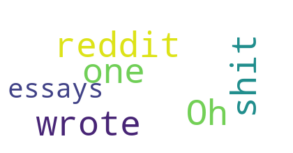

In [100]:
# Start with the first parent comment:
from wordcloud import WordCloud
parent = red_final.parent_comment[0]
print(parent)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(parent)

# Display the generated image:
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Wordcloud on all the parent comments:

In [101]:
# Wordcloud
def myWordCloud(label):
    reddit_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(red_final['parent_comment'][red_final["label"]==label]))
    plt.figure(figsize=(10,8), facecolor='k')
    plt.imshow(reddit_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

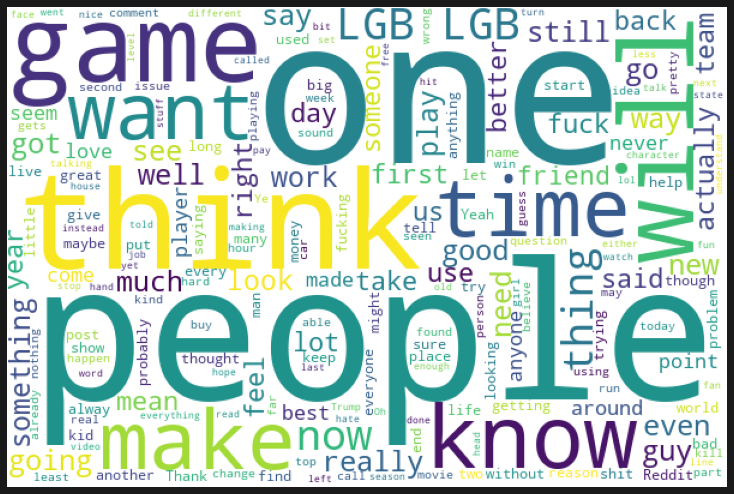

In [102]:
## Wordcloud for Non sarcastic comments
myWordCloud(0)

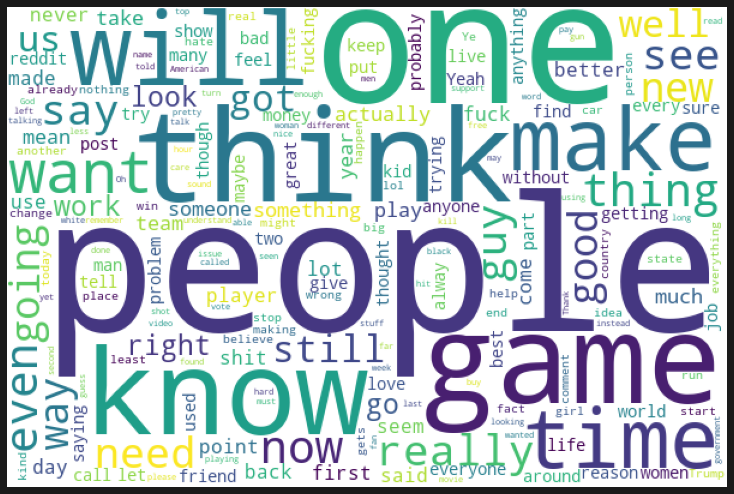

In [103]:
## Wordcloud for Sarcastic comments
myWordCloud(1)

Wordcloud with the cleaned version of the parent comments:

In [104]:
# Word cloud
def myWordCloudCleaned(label):
    reddit_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(red_final['clean'][red_final["label"]==label]))
    plt.figure(figsize=(10,8), facecolor='k')
    plt.imshow(reddit_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

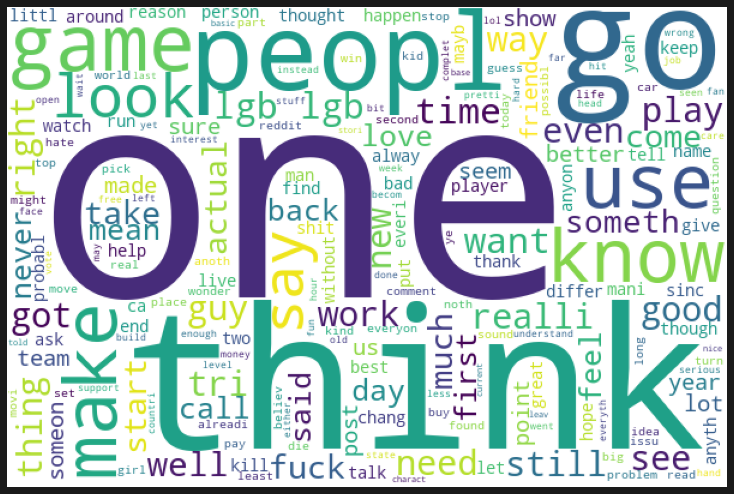

In [105]:
## Wordcloud for Non sarcastic comments
myWordCloudCleaned(0)

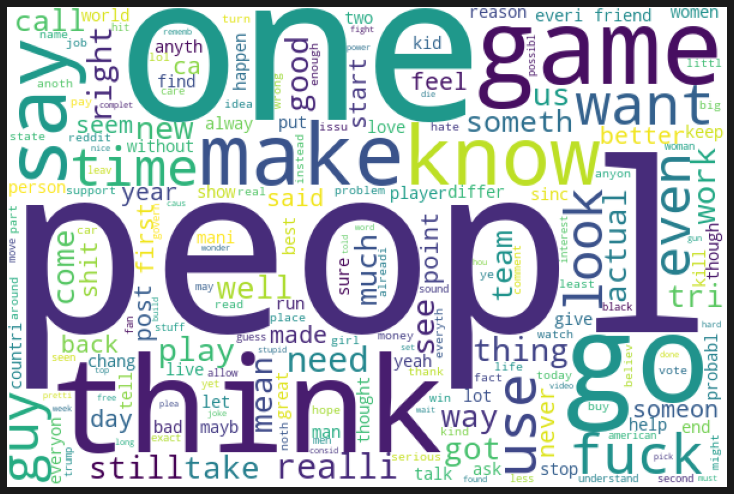

In [106]:
## Wordcloud for Sarcastic comments
myWordCloudCleaned(1)

## Split into train, test and validation set

In [107]:
red_final.rename(columns={'parent_comment':'parent'}, inplace=True)
red_final.head()

,label,subreddit,ups,downs,parent,char,punct,tokens,clean,sentiment,cap,uppercase,polarity,subjectivity
0,0,ApplyingToCollege,-1,-1,"Oh shit, I wrote about reddit as one of my ess...",50,2,11,oh shit wrote reddit one essay,Highly Negative,1,2,-0.200000,0.800000
1,1,atheism,4,0,Sacramento Baptist Preacher Praises Orlando Ga...,64,0,8,sacramento baptist preacher prais orlando gay ...,Positive,0,8,0.416667,0.583333
2,1,videos,4,0,Why isnt this criminal assualt? Are the police...,68,2,13,isnt crimin assualt polic fuck tsa,Negative,0,2,-0.500000,0.625000
3,1,worldnews,1,0,Serbia accuses Albania of provocation after brawl,49,0,7,serbia accus albania provoc brawl,Negative,0,2,0.000000,0.000000
4,1,news,18,0,"Hand over your guns guys, christ, get a grip.",45,3,9,hand gun guy christ get grip,Highly Positive,0,1,0.000000,0.000000


In [108]:
## Let's check the number of unique values in the subreddit columns
red_final['subreddit'].nunique()

5606

In [109]:
X = red_final.drop(['parent'], axis = 1) 

In [110]:
X = X.drop(['label'], axis = 1) 
y = red_final["label"]

In [112]:
#X = red_copy[['clean','subreddit']]
#y = red_copy['label']

In [235]:
X_train, red_test, y_train1, y_test = train_test_split(X, y, test_size=0.20, random_state=28)

In [236]:
red_train, red_val, y_train, y_val = train_test_split(X_train, y_train1, test_size=0.2, random_state=28)

In [237]:
print(red_train.shape)
print(red_val.shape)
print(red_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(64688, 12)
(16173, 12)
(20216, 12)
(64688,)
(16173,)
(20216,)


In [238]:
red_train.head()

,subreddit,ups,downs,char,punct,tokens,clean,sentiment,cap,uppercase,polarity,subjectivity
72677,CFB,1,0,73,3,14,foreal call us war eagl think someth us,Highly Negative,1,2,0.000000,0.000000
10531,NewYorkMets,4,0,73,2,16,hate night game way excit wish start,Negative,1,6,-0.275000,0.683333
97566,Philippines,1,0,83,3,15,back doc certif ca call unexcus absenc,Neutral,0,0,-0.006250,0.000000
74802,nba,-1,-1,58,1,11,kyri irv put cavali second left,Neutral,0,3,0.000000,0.000000
54306,Guildwars2,-1,0,307,9,59,sab tweak made almost easi infantil mode see p...,Negative,2,8,0.010714,0.744048


In [239]:
red_val.head()

,subreddit,ups,downs,char,punct,tokens,clean,sentiment,cap,uppercase,polarity,subjectivity
60690,mildlyinteresting,2,0,48,1,8,mold pineappl look like bubblegum,Positive,0,1,0.000000,0.000000
21264,fantasyfootball,-1,-1,48,2,9,awar peopl play money right,Positive,0,1,0.267857,0.392857
28271,europe,8,0,31,1,6,differ last time,Negative,0,1,0.000000,0.333333
41858,newzealand,1,0,267,12,43,trademark appli particular trade unless merced...,Highly Negative,1,10,-0.145833,0.708333
68294,NHLHUT,6,0,257,9,47,anybodi interest hang twitch play game guy giv...,Highly Positive,2,4,0.187500,0.700000


## Classification algorithms

### First alternative
In the first alternative we wll have separate Tf-Idf vectorizers for comments and for subreddits.

#### TF-IDF on cleaned parent comments

TF-IDF focusing on the parent comments from which we have removed the punctuation and on which we have performed stemmization. 

In [240]:
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer

In [241]:
parent_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=50000, min_df=2)
subreddits_vectorizer = TfidfVectorizer(ngram_range=(1, 1))

In [242]:
clean_train = parent_vectorizer.fit_transform(red_train['clean'])
clean_valid = parent_vectorizer.transform(red_val['clean'])
clean_test = parent_vectorizer.transform(red_test['clean'])

In [243]:
subred_train = subreddits_vectorizer.fit_transform(red_train['subreddit'])
subred_valid = subreddits_vectorizer.transform(red_val['subreddit'])
subred_test = subreddits_vectorizer.transform(red_test['subreddit'])

In [244]:
reddit_train = hstack([clean_train, subred_train])
reddit_valid = hstack([clean_valid, subred_valid])
reddit_test = hstack([clean_test, subred_test])

In [245]:
def addFeature(X, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [246]:
#features = np.append(vectorizer.get_feature_names(), ['char','cap','punt','uppercase'])

In [247]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE
NB = MultinomialNB()
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier as xgboost
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

#### Naive Bayes

In [248]:
naive_bayes = NB.fit(reddit_train, y_train)

In [249]:
naiveBayes_predict = naive_bayes.predict(reddit_test)

In [250]:
metrics.accuracy_score(y_test, naiveBayes_predict)

0.5780075187969925

Cross Validation:

In [251]:
NB_cv = cross_val_score(NB, reddit_train, y_train, n_jobs = -1)
NB_cv

array([0.56647086, 0.56260628, 0.56855774, 0.578032  , 0.57177089])

#### Logistic Regression

In [252]:
logit = lg(C=1, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)

In [253]:
## Fit the model
logit_model1 = logit.fit(reddit_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    3.0s finished


In [254]:
y_pred_logit1 = logit_model1.predict(reddit_test)

Accurcay 0.5750890383854372
Precision 0.5766465902467457
Recall 0.5837922895357985
F1 score 0.5801974391555078


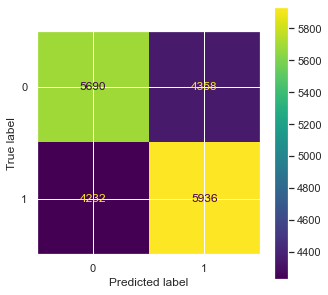

In [255]:
# print the model performance metrics
print("Accurcay",accuracy_score(y_test, y_pred_logit1))
print("Precision", precision_score(y_test, y_pred_logit1))
print("Recall",recall_score(y_test, y_pred_logit1))
print("F1 score",f1_score(y_test, y_pred_logit1))
plot_confusion_matrix(logit_model1, reddit_test, y_test)

#### KNN

In [256]:
knn_model1 = knn.fit(reddit_train, y_train) 

In [257]:
y_knn_pred1 = knn_model1.predict(reddit_test)
y_knn_pred1

array([0, 1, 0, ..., 1, 1, 1], dtype=int64)

In [258]:
print(knn_model1.score(reddit_test, y_test)) 

0.528640680648991


#### Random Forest

In [259]:
random_forest = RandomForestClassifier(max_depth=10, max_features=10)
random_forest_model1 = random_forest.fit(reddit_train, y_train)

In [260]:
randomForest_predict1 = random_forest_model1.predict(reddit_test)

In [261]:
metrics.accuracy_score(y_test, randomForest_predict1)

0.514592402057776

Cross Validation:

In [262]:
rf_cv1 = cross_val_score(random_forest_model1, reddit_train, y_train, n_jobs = -1)
rf_cv1

array([0.52125522, 0.51290771, 0.5121348 , 0.52601067, 0.51804901])

### Let's try with a new sentence
We decided to try with two questions from AskReddit

In [263]:
sent1 = {'subreddit': ['AskReddit'], 'parent': ['What is your dream job? (Serious)']}
proof = pd.DataFrame(sent1)

In [264]:
proof

,subreddit,parent
0,AskReddit,What is your dream job? (Serious)


In [265]:
X_sub1 = subreddits_vectorizer.transform(proof['subreddit'])
X_parent1 = parent_vectorizer.transform(proof['parent'])
X_sent1 = hstack([X_sub1, X_parent1])

In [266]:
X_sent1

<1x54563 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in COOrdinate format>

In [267]:
NB.predict_proba(X_sent1)

array([[0.29665382, 0.70334618]])

In [268]:
logit.predict_proba(X_sent1)

array([[0.41634052, 0.58365948]])

## Second Alternative

Adding the subreddit to the comment and therefore conduct the analysis on the combination of the two: since the subreddits are not classified as stopwords when parsing the comments they should not be removed, thus appearing in the cleaned version of the comments.

In [269]:
red_copy.head()

,label,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,text
0,0,ApplyingToCollege,-1,-1,"Oh shit, I wrote about reddit as one of my ess...",50,2,11,oh shit wrote reddit one essay,oh shit wrote reddit one essay ApplyingToCollege
1,1,atheism,4,0,Sacramento Baptist Preacher Praises Orlando Ga...,64,0,8,sacramento baptist preacher prais orlando gay ...,sacramento baptist preacher prais orlando gay ...
2,1,videos,4,0,Why isnt this criminal assualt? Are the police...,68,2,13,isnt crimin assualt polic fuck tsa,isnt crimin assualt polic fuck tsa videos
3,1,worldnews,1,0,Serbia accuses Albania of provocation after brawl,49,0,7,serbia accus albania provoc brawl,serbia accus albania provoc brawl worldnews
4,1,news,18,0,"Hand over your guns guys, christ, get a grip.",45,3,9,hand gun guy christ get grip,hand gun guy christ get grip news


In [270]:
red_copy['text'] = red_copy.clean + " " + red_copy.subreddit
red_copy.head()

,label,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,text
0,0,ApplyingToCollege,-1,-1,"Oh shit, I wrote about reddit as one of my ess...",50,2,11,oh shit wrote reddit one essay,oh shit wrote reddit one essay ApplyingToCollege
1,1,atheism,4,0,Sacramento Baptist Preacher Praises Orlando Ga...,64,0,8,sacramento baptist preacher prais orlando gay ...,sacramento baptist preacher prais orlando gay ...
2,1,videos,4,0,Why isnt this criminal assualt? Are the police...,68,2,13,isnt crimin assualt polic fuck tsa,isnt crimin assualt polic fuck tsa videos
3,1,worldnews,1,0,Serbia accuses Albania of provocation after brawl,49,0,7,serbia accus albania provoc brawl,serbia accus albania provoc brawl worldnews
4,1,news,18,0,"Hand over your guns guys, christ, get a grip.",45,3,9,hand gun guy christ get grip,hand gun guy christ get grip news


In [271]:
def myWordCloudText(label):
    reddit_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(red_copy['text'][red_copy["label"]==label]))
    plt.figure(figsize=(10,8), facecolor='k')
    plt.imshow(reddit_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

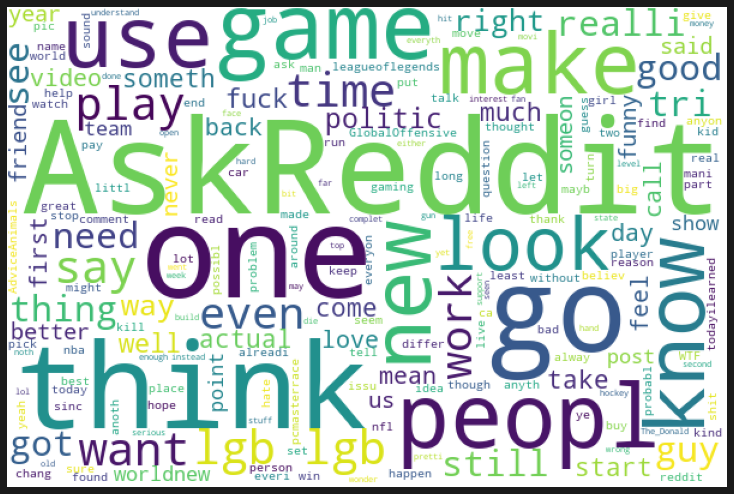

In [272]:
## Wordcloud for Non sarcastic comments
myWordCloudText(0)

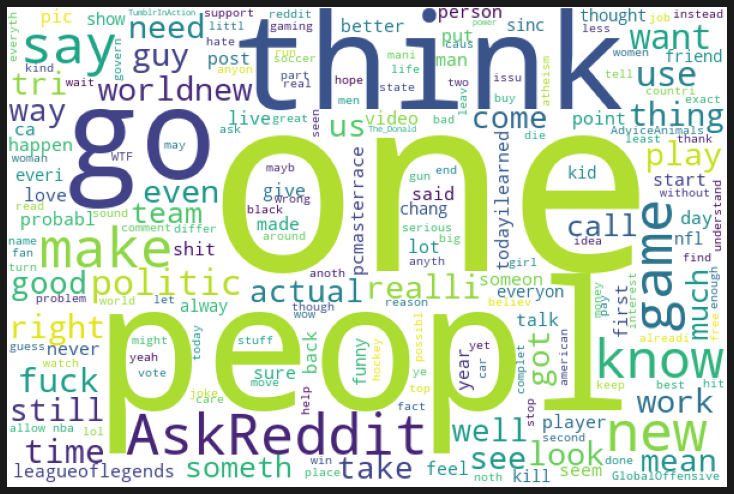

In [273]:
## Wordcloud for Non sarcastic comments
myWordCloudText(1)

In [274]:
X2 = red_copy[['text']]
y2 = red_copy['label']

In [275]:
X2

,text
0,oh shit wrote reddit one essay ApplyingToCollege
1,sacramento baptist preacher prais orlando gay ...
2,isnt crimin assualt polic fuck tsa videos
3,serbia accus albania provoc brawl worldnews
4,hand gun guy christ get grip news
...,...
101072,seem pure mathemat reveal topographi region wh...
101073,use bug killstreak kit make saxxi profession k...
101074,love look around someon els blame soccer
101075,negat meat popsicl AdviceAnimals


In [276]:
X_train2, red_test2, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=28)

In [277]:
clean_train2 = parent_vectorizer.fit_transform(X_train2['text'])
clean_test2 = parent_vectorizer.transform(red_test2['text'])

#### Naive Bayes

In [278]:
naive_bayes2 = NB.fit(clean_train2, y2_train)

In [279]:
naiveBayes_predict2 = naive_bayes2.predict(clean_test2)

In [280]:
metrics.accuracy_score(y2_test, naiveBayes_predict2)

0.5737039968341907

Cross Validation:

In [281]:
NB_cv2 = cross_val_score(NB, clean_train2, y2_train, n_jobs = -1)
NB_cv2

array([0.56359364, 0.56566906, 0.56968835, 0.56684393, 0.5701212 ])

#### Random forest

In [282]:
random_forest2 = RandomForestClassifier(max_depth=10, max_features=10)
random_forest2.fit(clean_train2, y2_train)

RandomForestClassifier(max_depth=10, max_features=10)

In [283]:
randomForest_predict2 = random_forest2.predict(clean_test2)

In [284]:
metrics.accuracy_score(y2_test, randomForest_predict2)

0.5108330035615354

Cross Validation:

In [285]:
rf_cv2 = cross_val_score(random_forest2, clean_train2, y2_train, n_jobs = -1)
rf_cv2

array([0.51351017, 0.5064927 , 0.51564432, 0.50871877, 0.50878061])

#### Logistic Regression

In [286]:
X2 = red_copy['text']
y2 = red_copy['label']

In [287]:
X_train2, red_test2, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=28)

In [288]:
from sklearn.pipeline import Pipeline
tf_idf2 = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
# multinomial logistic regression a.k.a softmax classifier
logit = lg(C=1, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)
# sklearn's pipeline
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf2), 
                                 ('logit', logit)])

In [289]:
tfidf_logit_pipeline.fit(X_train2, y2_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    2.1s finished


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=50000, min_df=2,
                                 ngram_range=(1, 2))),
                ('logit',
                 LogisticRegression(C=1, n_jobs=4, random_state=17,
                                    verbose=1))])

In [290]:
roc_auc_score(y2_test, tfidf_logit_pipeline.predict_proba(red_test2)[:,1])

0.6029388302787062

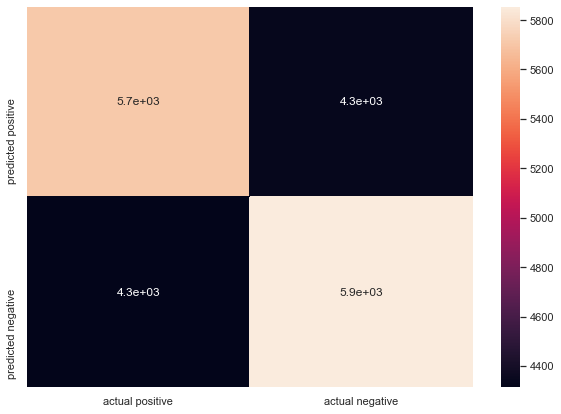

In [291]:
conf_mat2 = pd.DataFrame(confusion_matrix(y2_test, tfidf_logit_pipeline.predict(red_test2)), index = ['predicted positive', 'predicted negative'],
                  columns = ['actual positive', 'actual negative'])
plt.figure(figsize = (10,7))
sns.heatmap(conf_mat2, annot=True)
plt.show()

### Let's make an example

In [292]:
sent2 = {'text': ['AskReddit: What is your dream job? (Serious)']}
proof2 = pd.DataFrame(sent2)

In [293]:
proof2

,text
0,AskReddit: What is your dream job? (Serious)


In [294]:
X_parent2 = parent_vectorizer.transform(proof2['text'])

In [295]:
naive_bayes2.predict_proba(X_parent2)

array([[0.48123245, 0.51876755]])

In [296]:
X_parent2 = tf_idf2.transform(proof2['text'])

In [297]:
logit.predict_proba(X_parent2)

array([[0.39876579, 0.60123421]])

#### GridSeachCV:

In [298]:
model = Pipeline([('tfidf',TfidfVectorizer(min_df=2)),
                    ('logit', lg(solver='lbfgs', max_iter=3000))])
parameters = {'tfidf__ngram_range':[(1,1),(1,2)],'tfidf__use_idf':(True,False)}

In [299]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=parameters, verbose=2,n_jobs=-1, cv=3, refit=True)

In [300]:
grid.fit(X_train2, y2_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    6.8s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   17.7s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2)),
                                       ('logit',
                                        LogisticRegression(max_iter=3000))]),
             n_jobs=-1,
             param_grid={'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__use_idf': (True, False)},
             verbose=2)

In [301]:
chosen_model = Pipeline([('tfidf',TfidfVectorizer(min_df=2, ngram_range=(1,2),use_idf=True)),
                    ('logit', lg(solver='lbfgs', max_iter=3000))])
chosen_model.fit(X_train2, y2_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2, ngram_range=(1, 2))),
                ('logit', LogisticRegression(max_iter=3000))])

In [302]:
from sklearn.metrics import accuracy_score
predictions = chosen_model.predict(red_test2)
print('Accuracy Score: {:.2%}'.format(accuracy_score(y2_test,predictions)),'\n')

Accuracy Score: 57.45% 



### Third Alternative

In [303]:
X_train3, red_test3, y_train_prov, y_test3 = train_test_split(X, y, test_size=0.20, random_state=28)

In [304]:
red_train3, red_val3, y_train3, y_val3 = train_test_split(X_train3, y_train_prov, test_size=0.2, random_state=28)

#### TF-IDF Vectorizers

In [305]:
parent_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=50000, min_df=2)
subreddits_vectorizer = TfidfVectorizer(ngram_range=(1, 1))
sentiment_vectorizer = TfidfVectorizer(ngram_range=(1, 1))

In [306]:
clean_train3 = parent_vectorizer.fit_transform(red_train3['clean'])
clean_valid3 = parent_vectorizer.transform(red_val3['clean'])
clean_test3 = parent_vectorizer.transform(red_test3['clean'])

In [307]:
subred_train3 = subreddits_vectorizer.fit_transform(red_train3['subreddit'])
subred_valid3 = subreddits_vectorizer.transform(red_val3['subreddit'])
subred_test3 = subreddits_vectorizer.transform(red_test3['subreddit'])

In [308]:
sent_train = sentiment_vectorizer.fit_transform(red_train3['sentiment'])
sent_valid = sentiment_vectorizer.transform(red_val3['sentiment'])
sent_test = sentiment_vectorizer.transform(red_test3['sentiment'])

reddit_train3 = hstack([subred_train3, sent_train])
reddit_valid3 = hstack([subred_valid3, sent_valid])
reddit_test3 = hstack([subred_test3, sent_test])

In [309]:
reddit_train1_3 = hstack([clean_train3, subred_train3])
reddit_valid1_3 = hstack([clean_valid3, subred_valid3])
reddit_test1_3 = hstack([clean_test3, subred_test3])

In [310]:
reddit_train3 = hstack([reddit_train1_3, sent_train])
reddit_valid3 = hstack([reddit_valid1_3, sent_valid])
reddit_test3 = hstack([reddit_test1_3, sent_test])

In [311]:
reddit_train3 = addFeature(reddit_train3, red_train3['char'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['char'])
reddit_test3 = addFeature(reddit_test3, red_test3['char'])

In [312]:
reddit_train3 = addFeature(reddit_train3, red_train3['cap'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['cap'])
reddit_test3 = addFeature(reddit_test3, red_test3['cap'])

In [313]:
reddit_train3 = addFeature(reddit_train3, red_train3['punct'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['punct'])
reddit_test3 = addFeature(reddit_test3, red_test3['punct'])

In [314]:
reddit_train3 = addFeature(reddit_train3, red_train3['uppercase'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['uppercase'])
reddit_test3 = addFeature(reddit_test3, red_test3['uppercase'])

In [315]:
reddit_train3 = addFeature(reddit_train3, red_train3['ups'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['ups'])
reddit_test3 = addFeature(reddit_test3, red_test3['ups'])

In [316]:
reddit_train3 = addFeature(reddit_train3, red_train3['downs'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['downs'])
reddit_test3 = addFeature(reddit_test3, red_test3['downs'])

In [317]:
reddit_train3 = addFeature(reddit_train3, red_train3['polarity'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['polarity'])
reddit_test3 = addFeature(reddit_test3, red_test3['polarity'])

#### XGBoost

In [319]:
xgboost = XGBClassifier()
xgboost_model3 = xgboost.fit(reddit_train3, y_train3)
y_pred_xgboost3 = xgboost_model3.predict(reddit_test3)

In [320]:
accuracy_xgboost3 = accuracy_score(y_test3, y_pred_xgboost3)
print("Accuracy: %.2f%%" % (accuracy_xgboost3 * 100.0))

Accuracy: 58.36%


Confusion matrix:
 [[6553 3495]
 [4922 5246]]


C:\Users\liry9\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
C:\Users\liry9\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


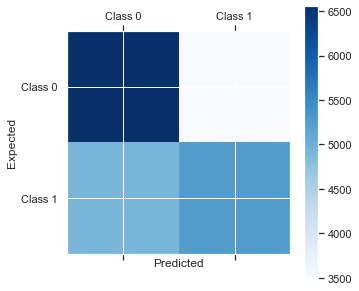

In [321]:
conf_mat_xbgoost3 = confusion_matrix(y_true = y_test3, y_pred = y_pred_xgboost3)
print('Confusion matrix:\n', conf_mat_xbgoost3)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat_xbgoost3, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

#### Logistic Regression

In [322]:
logit = lg(C=1, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)

In [323]:
## Fit the model
logit_model3 = logit.fit(reddit_train3, y_train3)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    3.5s finished


In [324]:
y_pred_logit3 = logit_model3.predict(reddit_test3)

Accurcay 0.5431341511673922
Precision 0.5426583668985719
Recall 0.5830055074744296
F1 score 0.5621088564384601


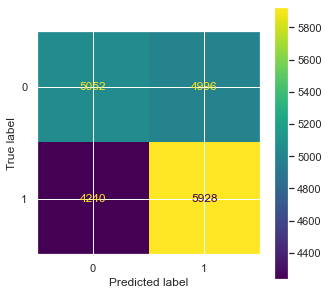

In [325]:
# print the model performance metrics
print("Accurcay",accuracy_score(y_test3, y_pred_logit3))
print("Precision", precision_score(y_test3, y_pred_logit3))
print("Recall",recall_score(y_test3, y_pred_logit3))
print("F1 score",f1_score(y_test3, y_pred_logit3))
plot_confusion_matrix(logit_model3, reddit_test3, y_test3)

#### KNN

In [326]:
knn_model3 = knn.fit(reddit_train3, y_train3) 

In [327]:
y_knn_pred3 = knn_model3.predict(reddit_test3)
y_knn_pred3

array([0, 0, 1, ..., 0, 1, 1], dtype=int64)

In [328]:
print(knn_model3.score(reddit_test3, y_test3)) 

0.513405223585279


#### Random Forest

In [329]:
random_forest_model3 = random_forest.fit(reddit_train3, y_train3)

In [330]:
randomForest_predict3 = random_forest_model3.predict(reddit_test3)

In [331]:
metrics.accuracy_score(y_test3, randomForest_predict3)

0.5118717847249703

Cross Validation

In [333]:
rf_cv3 = cross_val_score(random_forest_model3, reddit_train3, y_train3, n_jobs = -1)
rf_cv3

array([0.52705209, 0.52581543, 0.52481064, 0.51967226, 0.51418412])

## PCA Analysis for dimensionality reduction

https://www.datacamp.com/community/tutorials/categorical-data

In [334]:
category = red_copy['subreddit'].astype('category').cat.categories.tolist()
replace_sub = {'subreddit' : {k: v for k,v in zip(category, list(range(1,len(category)+1)))}}

In [335]:
red_copy.replace(replace_sub, inplace=True)

In [336]:
red_copy.head()

,label,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,text
0,0,177,-1,-1,"Oh shit, I wrote about reddit as one of my ess...",50,2,11,oh shit wrote reddit one essay,oh shit wrote reddit one essay ApplyingToCollege
1,1,2994,4,0,Sacramento Baptist Preacher Praises Orlando Ga...,64,0,8,sacramento baptist preacher prais orlando gay ...,sacramento baptist preacher prais orlando gay ...
2,1,5439,4,0,Why isnt this criminal assualt? Are the police...,68,2,13,isnt crimin assualt polic fuck tsa,isnt crimin assualt polic fuck tsa videos
3,1,5546,1,0,Serbia accuses Albania of provocation after brawl,49,0,7,serbia accus albania provoc brawl,serbia accus albania provoc brawl worldnews
4,1,4481,18,0,"Hand over your guns guys, christ, get a grip.",45,3,9,hand gun guy christ get grip,hand gun guy christ get grip news


In [337]:
## TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=3)
R = vectorizer.fit_transform(red_copy["clean"])
print(R.shape)
type(R)

(101077, 70422)


scipy.sparse.csr.csr_matrix

In [338]:
#L = vectorizer.fit_transform(red_copy["subreddit"])
#print(R.shape)
#type(R)

In [339]:
# We can use hstack to merge two sparse matrices, without having to convert to dense format.
def addFeature(R, feature_to_add):  
    return hstack([R, csr_matrix(feature_to_add).T], 'csr')

In [340]:
R = addFeature(R, red_copy['subreddit'])

In [341]:
print(R.shape)

(101077, 70423)


In [342]:
features = np.append(vectorizer.get_feature_names(), ['Sub'])

In [343]:
features

array(['aa', 'aaa', 'aaa game', ..., 'zulrah', 'zyra', 'Sub'],
      dtype='<U23')

In [344]:
y_label = red_copy['label']

In [345]:
from sklearn.feature_selection import SelectKBest, chi2
selector = SelectKBest(chi2, k=20) 
R_new = selector.fit_transform(R, y_label)
print(R_new.shape)

(101077, 20)


In [346]:
features[selector.get_support()]

array(['black', 'blame', 'drug', 'episod', 'gay', 'govern', 'irl', 'male',
       'muslim', 'peopl', 'polic', 'racist', 'rape', 'sarcasm', 'sarcast',
       'thank', 'white', 'woman', 'women', 'Sub'], dtype='<U23')

In [347]:
# compute chi2 scores for features and sort them from most to less relevant
from sklearn.feature_selection import chi2
stat, pval = chi2(R,y_label)
score = list(zip(features, stat, pval))
score.sort(key = lambda tup: tup[2])
score

[('Sub', 223727.2419317526, 0.0),
 ('sarcasm', 32.14032709918478, 1.4342901466377462e-08),
 ('women', 29.989053061675584, 4.344922898955897e-08),
 ('peopl', 29.112438698895165, 6.829708073220574e-08),
 ('irl', 26.0578514417499, 3.313386907340203e-07),
 ('thank', 25.78260741629804, 3.8211637386576313e-07),
 ('rape', 24.917966384390166, 5.982230937831894e-07),
 ('white', 21.75388475024447, 3.099615915571749e-06),
 ('racist', 19.182567337305898, 1.1879330457667294e-05),
 ('polic', 16.90395786032523, 3.931951285613237e-05),
 ('muslim', 15.728015605495951, 7.313293797275497e-05),
 ('woman', 14.97305341708618, 0.00010905744238951364),
 ('gay', 14.23877949630365, 0.00016101793907510517),
 ('male', 11.316154933672378, 0.0007683565518814527),
 ('sarcast', 11.269332120787041, 0.0007879807374520043),
 ('blame', 11.098751827392293, 0.0008638584085667415),
 ('black', 11.098417893324973, 0.0008640139728560423),
 ('episod', 10.976197138598952, 0.0009228961779178146),
 ('drug', 10.640482491542013, 0.0

In [348]:
# select features with p-val less than 1%
sel = np.flatnonzero(pval < 0.01)
R_sel = R[:,sel]
features_sel = features[sel]
R_sel

<101077x50 sparse matrix of type '<class 'numpy.float64'>'
	with 129753 stored elements in Compressed Sparse Row format>

In [349]:
# Scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
R_scale = scaler.fit_transform(R_sel.toarray())

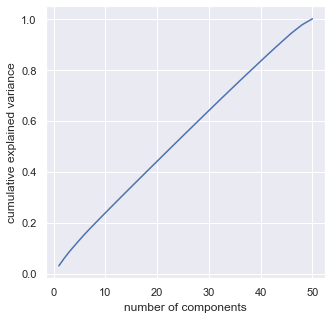

In [351]:
# PCA
from sklearn.decomposition import PCA

pca = PCA().fit(R_scale)
nc  = list(range(1,1+len(pca.explained_variance_ratio_)))
ev  = np.cumsum(pca.explained_variance_ratio_)
plt.plot(nc, ev)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()